In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [3]:
import tensorflow as tf

In [4]:
from tqdm import tqdm
import cv2
import os
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle as sk_shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_datasets as tfds

In [5]:
from src.data import get_data
from src.data import get_image_value

In [6]:
dim = (224,224)
model_type = 'Mobilenet'
bw = False

In [7]:
class_model_folder = f"./data/models/mobilnet/"
ignore_file = '.ipynb_checkpoints'

In [8]:
dir_prefix = './data/images/class_test/'
test_paths = os.listdir(dir_prefix)
if ignore_file in test_paths:
    idx = test_paths.index(ignore_file)
    test_paths.pop(idx)
    
test_paths = sorted(test_paths)
test_images = np.array([get_image_value(os.path.join(dir_prefix, i), dim, bw, model_type) for i in test_paths])

In [9]:
test_labels = []
for file in test_paths:
    if 'f' in file:
        test_labels.append(0)
    else:
        test_labels.append(1)

In [10]:
train_paths, train_labels = get_data('train')
train_images = np.array([get_image_value(i, dim, bw, model_type) for i in train_paths])
train_dict = dict(images = train_images, labels = train_labels)

TRAIN Value Counts
0    367
1    309
dtype: int64


In [11]:
valid_paths, valid_labels = get_data('valid')
valid_images = np.array([get_image_value(i, dim, bw, model_type) for i in valid_paths])
valid_dict = dict(images = valid_images, labels = valid_labels)

VALID Value Counts
1    162
0     62
dtype: int64


In [12]:
#test_paths, test_labels = get_data('test')
#test_images = np.array([get_image_value(i, dim, bw, model_type) for i in test_paths])
#test_dict = dict(images = test_images, labels = test_labels)

In [13]:
data_dir = './data/images/syn/'
img_height = 224
img_width = 224
learing_rate = 5e-4
batch_size = 16

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  f"{data_dir}/training",
  #validation_split=0.2,
  #subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
  f"{data_dir}/validation",
  #validation_split=0.2,
  #subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

In [14]:
train_images.shape

(676, 224, 224, 3)

In [15]:
x_train = train_images
y_train = train_labels
x_valid = valid_images
y_valid = valid_labels
x_test = test_images
y_test = np.array(test_labels)

In [16]:
from src.model import MobileNet

# Classification Task 

In [17]:
save_file_name = os.path.join(class_model_folder,f'mobilenet_batch_add_conv_{batch_size}_lr_{learing_rate}_.h5')
model = MobileNet(#input_shape = (224,224,3),
                  train_data=(x_train, y_train),
                  valid_data=(x_test, y_test),
                  lr=learing_rate,
                  batch_size=batch_size,
                  model_save_dir=save_file_name)

/home/jupyter/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
43/43 [==============================] - 14s 209ms/step - loss: 0.6931 - accuracy: 0.5430 - val_loss: 0.6534 - val_accuracy: 0.6250

Epoch 00001: val_loss improved from inf to 0.65345, saving model to ./data/models/mobilnet/mobilenet_batch_add_conv_16_lr_0.0005_.h5
Epoch 2/200
43/43 [==============================] - 6s 144ms/step - loss: 0.6317 - accuracy: 0.6435 - val_loss: 0.5267 - val_accuracy: 0.7812

Epoch 00002: val_loss improved from 0.65345 to 0.52667, saving model to ./data/models/mobilnet/mobilenet_batch_add_conv_16_lr_0.0005_.h5
Epoch 3/200
43/43 [==============================] - 6s 143ms/step - loss: 0.4660 - accuracy: 0.7885 - val_loss: 0.4364 - val_accuracy: 0.7734

Epoch 00003: val_loss improved from 0.52667 to 0.43644, saving model to ./data/models/mobilnet/mobilenet_batch_add_conv_16_lr_0.0005_.h5
Epoch 4/200
43/43 [==============================] - 6s 143ms/step - loss: 0.3260 - accuracy: 0.8632 - val_loss: 0.4222 - val_accuracy: 0.8438

Epoch 00004: val

In [16]:
from sklearn.metrics import accuracy_score

In [19]:


cls_model_list = os.listdir(class_model_folder)
if ignore_file in cls_model_list:
    idx = cls_model_list.index(ignore_file)
    cls_model_list.pop(idx)

In [20]:
test_output_list = {}
for model_file in cls_model_list:
    model = tf.keras.models.load_model(os.path.join(class_model_folder, model_file))
    pred = model.predict(x_test)
    df_tmp = pd.DataFrame()
    df_tmp['file'] = test_paths
    df_tmp['prob'] = np.reshape(pred, (len(pred), ))
    df_tmp['pred'] = (df_tmp['prob']>0.5).astype(int)
    df_tmp['true'] = y_test
    print (f"Model name : {model_file}, Acc : {accuracy_score(df_tmp['true'], df_tmp['pred']):.2f}")
    test_output_list[model_file] = df_tmp

Model name : mobilenet_batch32_lr2e4_val_loss_0.18656.h5, Acc : 0.94
Model name : mobilenet_batch8_lr_0.0005_val_loss_0.19687.h5, Acc : 0.94
Model name : mobilenet_batch16_lr2e4_val_loss_0.18929.h5, Acc : 0.94
Model name : mobilenet_batch64_lr1e4.h5, Acc : 0.81
Model name : mobilenet_batch64_lr_2e5.h5, Acc : 0.88
Model name : mobilenet_batch16_lr_0.0005_val_loss_0.2328.h5, Acc : 0.92
Model name : mobilenet_batch_add_conv_16_lr_0.0005_.h5, Acc : 0.94
Model name : mobilenet_batch16_lr_0.0005_.h5, Acc : 0.94
Model name : mobilenet_batch16_lr_5e4_val_loss_0.17087.h5, Acc : 0.95
Model name : mobilenet_batch16_lr1e4_val_loss_0.275.h5, Acc : 0.88
Model name : mobilenet_batch16_lr_0.001_val_loss_0.24776.h5, Acc : 0.94


In [92]:
tmp_cls = "mobilenet_batch16_lr_5e4_val_loss_0.17087.h5"
test_output_list[tmp_cls][test_output_list[tmp_cls]['pred']!=test_output_list[tmp_cls]['true']]

,file,prob,pred,true
0,f_00.jpg,0.586945,1,0
8,f_08.jpg,0.934553,1,0
9,f_09.jpg,0.771903,1,0
39,f_39.jpg,0.653129,1,0
41,f_41.jpg,0.525457,1,0
79,t_12.jpg,0.440546,0,1
112,t_45.jpg,0.491136,0,1


In [48]:
tmp_cls = "mobilenet_batch32_lr2e4_val_loss_0.18656.h5"
test_output_list[tmp_cls][test_output_list[tmp_cls]['pred']!=test_output_list[tmp_cls]['true']]

,file,prob,pred,true
0,f_00.jpg,0.577684,1,0
8,f_08.jpg,0.937778,1,0
9,f_09.jpg,0.893094,1,0
39,f_39.jpg,0.687143,1,0
41,f_41.jpg,0.589327,1,0
54,f_54.jpg,0.592520,1,0
115,t_48.jpg,0.436313,0,1
124,t_57.jpg,0.449710,0,1


# Class Heatmap

In [17]:
tmp_cls = "mobilenet_batch_add_conv_16_lr_0.0005_.h5"#"mobilenet_batch16_lr_5e4_val_loss_0.17087.h5"
model = tf.keras.models.load_model(os.path.join(class_model_folder, tmp_cls))

In [72]:
tmp_cls = "mobilenet_batch16_lr_5e4_val_loss_0.17087.h5"
test_output_list[tmp_cls][test_output_list[tmp_cls]['pred']!=test_output_list[tmp_cls]['true']]

,file,prob,pred,true
0,f_00.jpg,0.586945,1,0
8,f_08.jpg,0.934553,1,0
9,f_09.jpg,0.771903,1,0
39,f_39.jpg,0.653129,1,0
41,f_41.jpg,0.525457,1,0
79,t_12.jpg,0.440546,0,1
112,t_45.jpg,0.491136,0,1


In [73]:
tmp_cls = "mobilenet_batch_add_conv_16_lr_0.0005_.h5"
test_output_list[tmp_cls][test_output_list[tmp_cls]['pred']!=test_output_list[tmp_cls]['true']]

,file,prob,pred,true
8,f_08.jpg,0.722314,1,0
9,f_09.jpg,0.673527,1,0
10,f_10.jpg,0.591643,1,0
39,f_39.jpg,0.840606,1,0
41,f_41.jpg,0.795233,1,0
68,t_01.jpg,0.359938,0,1
71,t_04.jpg,0.211109,0,1
112,t_45.jpg,0.231638,0,1


In [18]:
last_conv_layer_name = 'HeatLayer'#'mobilenetv2_1.00_224'

In [19]:
from src.utils import disply_heatmap

In [30]:
img_list = [18, 42, 45, 22, 63, 112, 69, 49, 65]
heat_list = []
for i in img_list:
    heat_list.append(disply_heatmap(x_test[i], model, last_conv_layer_name))

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


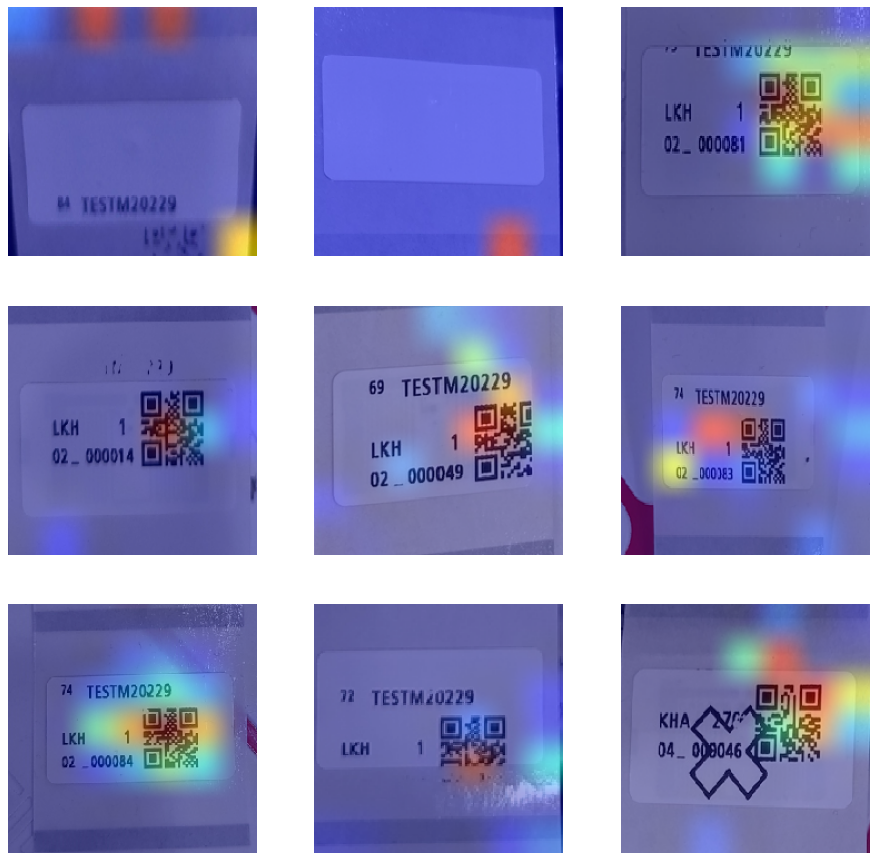

In [36]:
max_row = 3
max_col = 3
fig, ax = plt.subplots(max_row, max_col, figsize=(14,14), dpi=80)
for i in range(max_row*max_col):
    rw = int(i/max_col)
    cl = i%max_col
    #print (i, rw, cl)
    ax[rw, cl].axis('off')
    ax[rw, cl].imshow(heat_list[i])